# Teched 2022 - DA180 Session - Exercise 5

## Multi Model ML Scenario and data reference

Create a machine learning model to forecast the fuel prices for the service stations in the Rhein-Neckar district based on 
the tanker König dataset.

The dataset is published on the public website “Tankerkönig“ (http://www.tankerkoenig.de/). This dataset contains the gas prices of all gas stations in Germany from 2014 until today as csv files. A record contains the station id, the datetime, prices for diesel, e5 and e10 and a change indicator. In a separate csv the data of the service stations including its geolocation is provided. 

We use the stations and prices data within this website only for blog posting and demonstration
purpose. For non-commercial use the data is availble with the following license agreement (https://creativecommons.org/licenses/by-nc-sa/4.0/)
Data download from https://dev.azure.com/tankerkoenig/_git/tankerkoenig-data?path=/prices/2022  

Landkreise https://data.opendatasoft.com/explore/dataset/georef-germany-kreis%40public/export/?disjunctive.lan_code&disjunctive.lan_name&disjunctive.krs_code&disjunctive.krs_name&disjunctive.krs_name_short![image.png](attachment:image.png)
This dataset is licensed under : Data licence Germany – attribution – version 2.0 https://www.govdata.de/dl-de/by-2-0
1) Jede Nutzung ist unter den Bedingungen dieser „Datenlizenz Deutschland – Namensnennung – Version 2.0" zulässig.

Die bereitgestellten Daten und Metadaten dürfen für die kommerzielle und nicht kommerzielle Nutzung insbesondere

vervielfältigt, ausgedruckt, präsentiert, verändert, bearbeitet sowie an Dritte übermittelt werden;
mit eigenen Daten und Daten Anderer zusammengeführt und zu selbständigen neuen Datensätzen verbunden werden;
in interne und externe Geschäftsprozesse, Produkte und Anwendungen in öffentlichen und nicht öffentlichen elektronischen Netzwerken eingebunden werden.
(2) Bei der Nutzung ist sicherzustellen, dass folgende Angaben als Quellenvermerk enthalten sind:

Bezeichnung des Bereitstellers nach dessen Maßgabe,
der Vermerk „Datenlizenz Deutschland – Namensnennung – Version 2.0" oder „dl-de/by-2-0" mit Verweis auf den Lizenztext unter www.govdata.de/dl-de/by-2-0 sowie
einen Verweis auf den Datensatz (URI).
Dies gilt nur soweit die datenhaltende Stelle die Angaben 1. bis 3. zum Quellenvermerk bereitstellt.

(3) Veränderungen, Bearbeitungen, neue Gestaltungen oder sonstige Abwandlungen sind im Quellenvermerk mit dem Hinweis zu versehen, dass die Daten geändert wurden.

## Import the requied python packages

In [4]:
import hdbcli
import hana_ml
print(hana_ml.__version__)
from hana_ml import dataframe
from hana_ml.dataframe import create_dataframe_from_pandas, create_dataframe_from_shapefile

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon




2.14.22091801


## Connect to hana database

In [ ]:
host = '[YourHostName]'
port = 443
user = '[YourUser]'
passwd = '[YourUserPassword]'

In [3]:
#conn = dataframe.ConnectionContext(url, port, user, pwd)
conn= dataframe.ConnectionContext(address=host, port=port, user=user, password=passwd,
                               encrypt='true' ,sslValidateCertificate='false')

In [5]:
#conn = dataframe.ConnectionContext( address="<machine>", port=<SQL-port>,  user="<HANA-user>", password="<password>")
hc_url = '859c0f95-60f9-4540-aa81-581a8e452c6f.hna1.canary-eu10.hanacloud.ondemand.com'
conn = dataframe.ConnectionContext( address=hc_url, port=443, user="TECHED_USER_999", password='TechEd22Welcome' )
conn.hana_version()

'4.00.000.00.1663064250 (fa/CE2022.30)'

# Ex 5 - Apply Forecasting to multi-model data

# Ex 5.1 - Load, prepare and explore fuel station datasets

Clone data from https://github.com/SAP-samples/teched2022-DA180/tree/main/data/fuelprice

In [3]:
#!dir fuelprice
!dir datasets

 Volume in drive C is OSDisk
 Volume Serial Number is 72BC-6B0D

 Directory of C:\Users\D059078\OneDrive - SAP SE\Documents\D059078_Docs\_Projekte\python\PythonNotebooks\##events\#22TE\FuelPriceForecast\datasets

02.10.2022  09:39    <DIR>          .
02.10.2022  09:39    <DIR>          ..
14.09.2022  16:33         3,720,892 AX_Gebiet_Kreis.shp
02.10.2022  09:39    <DIR>          georef-germany-kreis
05.10.2022  11:21           818,730 georef-germany-kreis-millesime.dbf
05.10.2022  11:21         6,810,700 georef-germany-kreis-millesime.shp
02.10.2022  09:32         5,542,990 georef-germany-kreis.zip
22.09.2022  10:18    <DIR>          OD_AX_Gebiet_Kreis
14.09.2022  16:33         1,896,433 stations.csv
14.09.2022  16:33         1,242,543 test_groundtruth.csv
14.09.2022  16:33         1,206,725 test_rnk.csv
14.09.2022  16:33        25,064,170 train_rnk.csv
               8 File(s)     46,303,183 bytes
               4 Dir(s)  449,718,611,968 bytes free


## Step 1 - Load station data csv file 
https://dev.azure.com/tankerkoenig/_git/tankerkoenig-data?path=/stations/stations.csv

In [6]:
# load gas station data from csv
stations_pd = pd.read_csv('./datasets/stations.csv', sep=',', header=None, skiprows=1,
                          names=["uuid","name", "brand", "street","house_number",
                                  "post_code", "city", "latitude", "longitude"])

# create hana dataframe/DB table from pandas dataframe
stations_hdf = create_dataframe_from_pandas(
        conn,
        stations_pd,
        schema='TECHED_USER_999',
        table_name="GAS_STATIONS",
        force=True,
        replace=True,
        drop_exist_tab=False,
        geo_cols=[("longitude", "latitude")], srid=4326
    )

print("There are", stations_hdf.count(), "service stations in Germany", "\n")

stations_hdf.head(2).collect()

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]

There are 15442 service stations in Germany 



,uuid,name,brand,street,house_number,post_code,city,latitude,longitude,longitude_latitude_GEO
0,00060723-0001-4444-8888-acdc00000001,BAGeno Raiffeisen eG,None,Künzelsauer Strasse,7,74653,Ingelfingen,49.296822,9.661385,POINT (9.661384582519501 49.296821594238)
1,005056ba-7cb6-1ed2-bceb-5332ab168d12,famila Tankstelle,FAMILA,Pascalstrasse,9,25442,Quickborn,53.742150,9.941240,POINT (9.941239999999999 53.74215)


## Step 2 - Load  regional boundary Shapefile 

In [7]:
# create dataframe from shapefile for german regions "Landreise"
regions_hdf = create_dataframe_from_shapefile(
  connection_context=conn,
  shp_file='./datasets/georef-germany-kreis.zip',
  srid=25832,
  schema='TECHED_USER_999',
  table_name="GEO_GERMANY_REGIONS")

regions_hdf.drop('year').head(5).collect()

,lan_code,lan_name,krs_code,krs_name,krs_area_co,krs_type,krs_name_sh,SHAPE
0,03,Niedersachsen,03460,Landkreis Vechta,DEU,Landkreis,Vechta,"POLYGON ((8.459274000000001 52.801056, 8.4603 ..."
1,09,Bayern,09671,Landkreis Aschaffenburg,DEU,Landkreis,Aschaffenburg,"POLYGON ((9.40498 50.08774, 9.402760000000001 ..."
2,03,Niedersachsen,03155,Landkreis Northeim,DEU,Landkreis,Northeim,"(POLYGON ((9.8949 51.90616, 9.89282 51.905075,..."
3,03,Niedersachsen,03451,Landkreis Ammerland,DEU,Landkreis,Ammerland,"POLYGON ((8.173920000000001 53.35404, 8.167730..."
4,05,Nordrhein-Westfalen,05978,Kreis Unna,DEU,Kreis,Unna,"POLYGON ((7.40955 51.66458, 7.41054 51.663895,..."


## Step 3 -  Identify fuel station in local region

In [8]:
# filter service stations in Germany to those regions the close to SAP Headquarters "Rhein-Neckar-Kreis",
# Mannheim and Heidelberg 
stations_rnk_hdf = stations_hdf.join(regions_hdf, 
  '"longitude_latitude_GEO".ST_SRID(25832).st_transform(25832).st_intersects(SHAPE)=1').filter(
  "\"krs_name\"='Landkreis Rhein-Neckar-Kreis' or \"krs_name\"='Stadtkreis Heidelberg' or \"krs_name\"='Stadtkreis Mannheim'"
  )

# Show the SQL statement for the HANA dataframe "stations_rnk_hdf"
print(stations_rnk_hdf.select_statement, "\n")

# Show the number of service stations in selected spatial area
print("Number of Serice Stations in the Rhein-Neckar area", stations_rnk_hdf.count())

SELECT * FROM (SELECT * FROM (SELECT "uuid", "name", "brand", "street", "house_number", "post_code", "city", "latitude", "longitude", "longitude_latitude_GEO" FROM (SELECT * FROM "TECHED_USER_999"."GAS_STATIONS") dt) AS "DT_6" INNER JOIN (SELECT * FROM "TECHED_USER_999"."GEO_GERMANY_REGIONS") AS "DT_11" ON "longitude_latitude_GEO".ST_SRID(25832).st_transform(25832).st_intersects(SHAPE)=1) AS "DT_14" WHERE "krs_name"='Landkreis Rhein-Neckar-Kreis' or "krs_name"='Stadtkreis Heidelberg' or "krs_name"='Stadtkreis Mannheim' 

Number of Serice Stations in the Rhein-Neckar area 171


## Step 4 -  Visualize stations on map

In [16]:
# filter service stations in Germany to those NOT within the "Rhein-Neckar-Kreis"-region
stations_GER_hdf = stations_hdf.join(regions_hdf, 
 '"longitude_latitude_GEO".ST_SRID(25832).st_transform(25832).st_intersects(SHAPE)=1').filter(
 "\"krs_name\"!='Landkreis Rhein-Neckar-Kreis' AND \"krs_name\"!='Stadtkreis Heidelberg' AND \"krs_name\"!='Stadtkreis Mannheim'"
 )

# number of service stations in Germany, excluding the ones selected around the SAP Headquarters and area
print("Number of Service Stations in Germany, excluding the one in 'Rhein-Neckar-Kreis'-region",stations_GER_hdf.count())

Number of Service Stations in Germany, excluding the one in 'Rhein-Neckar-Kreis'-region 15263


In [17]:
# Collecting the HANA dataframe fuel stations point location spatial data for visualization into geopandas dataframes
stations_rnk_pd = stations_rnk_hdf.collect()
stations_rnk_geopands = gpd.GeoDataFrame(
    stations_rnk_pd, geometry=gpd.points_from_xy(stations_rnk_pd.longitude, stations_rnk_pd.latitude))

stations_GER_pd = stations_GER_hdf.collect()
stations_GER_geopands = gpd.GeoDataFrame(
    stations_GER_pd, geometry=gpd.points_from_xy(stations_GER_pd.longitude, stations_GER_pd.latitude))

# Collecting the HANA dataframe Germany region sspatial data for visualization into a geopandas dataframe
regions_pd = regions_hdf.collect()
regions_geopands = gpd.GeoDataFrame(regions_pd, geometry='SHAPE')

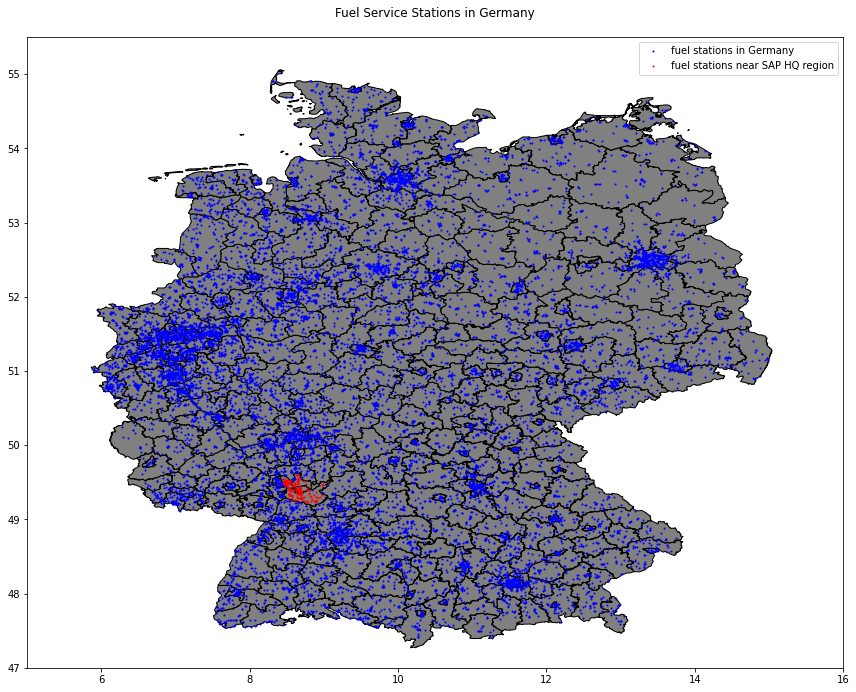

In [19]:
#Plot gepandas dataframes 
fig, ax = plt.subplots(figsize=(12,12))
ax.set_xlim((5,16))
ax.set_ylim((47,55.5))

regions_geopands.plot(ax=ax, facecolor='Grey', edgecolor='k')
stations_GER_geopands.plot(ax=ax, marker='.',  color='blue', markersize=4, label='fuel stations in Germany ')
stations_rnk_geopands.plot(ax=ax, marker='.',  color='red', markersize=4, label='fuel stations near SAP HQ region')

ax.legend()
ax.set_title('Fuel Service Stations in Germany', pad=20)
fig = ax.get_figure()
fig.tight_layout()

#  Exercise 5.2 - Load, prepare and explore fuel price datasets

Prerequisite: the fuel price records for the currenty year is loaded into a HANA DB table. Due to the size of the dataset, this is not inclued in the git repo. We only provide the resulting datasets for training, testing and the corresponding ground truth. Those dataset are small enough to be included in the git repository.


## Step 1 -  Load Fuel price csv file(s) 

In [22]:
# retrieve hana fuel price csv-file name into a Python list
mypath='./datasets/09/09'
from os import listdir
from os.path import isfile, join
pricefiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
#pricefiles

# load fuel price data for the 
gp_tmp_pd = {}
for file in pricefiles:
    gp_tmp_pd[file] = pd.read_csv('./datasets/09/09/{}'.format(file), sep=',', header=0, skiprows=1,
                                      names=["date", "station_uuid", "diesel", "e5", "e10", "dieselchange", "e5change", "e10change"],
                                      usecols=["date", "station_uuid", "diesel", "e5", "e10", "dieselchange", "e5change", "e10change"])
    gasprices_hdf = create_dataframe_from_pandas(
        conn, gp_tmp_pd[file],
        schema='TECHED_USER_999', table_name="GAS_PRICES",
        append=True)
    
# Show row count for uploaded fuel price data
gasprices_hdf.count()

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:14<00:00,  1.76s/it]


In [23]:
gasprices_hdf.count()

10575771

## Step 2 -  Analysis of fuel price data

In [24]:
# create hana dataframe including all gas prices in Germany in 2022 uploaded
fuelprice_all_hdf = conn.sql('select * from "RAW_DATA"."GAS_PRICES"')

print("There are", fuelprice_all_hdf.count(), "records in the dataset", "\n")

fuelprice_all_hdf.sort('date', desc=True).head(3).collect()

There are 90931410 records in the dataset 



,date,station_uuid,diesel,e5,e10,dieselchange,e5change,e10change
0,2022-09-30 23:59:09,51ba10bc-cefc-4544-88e8-0d830b11e961,2.099,1.999,1.939,1,1,1
1,2022-09-30 23:59:09,5a218a69-d93f-446a-99e4-79ed9b5d5183,1.989,1.879,1.859,0,1,1
2,2022-09-30 23:59:09,1674639b-579b-49ea-8e6b-7ad8d75c38e0,1.999,1.879,1.829,1,1,1


In [29]:
# Selecting columns in focus
fuelprice_all_hdf=fuelprice_all_hdf.select('date', 'station_uuid', 'e5')
#display(fuelprice_all_hdf.head(3).collect())

# Count the price changes per fuel service station
display(fuelprice_all_hdf.agg([('count', 'e5', 'N')], group_by='station_uuid').collect())

,date,station_uuid,e5
0,2022-07-30 19:01:08,c82ccef2-0eb8-41aa-80fc-ce45502575ad,1.749
1,2022-07-26 22:01:07,a954fdb2-3900-46b7-a0b0-6bbe9dc867c6,1.749
2,2022-07-25 22:01:07,a954fdb2-3900-46b7-a0b0-6bbe9dc867c6,1.749


,station_uuid,N
0,436782d2-cf94-408c-9715-693f0be4b091,5579
1,a1ea6437-ddbc-4f1c-a5bb-2b5fa33f8e7e,6817
2,a19a5477-304e-4a99-adc5-3b2282c11297,2822
3,3aeed500-8dda-4bd8-be55-d13e415e81b1,6477
4,7221415e-d627-40c6-be7f-285cf6744492,11584
...,...,...
15297,722ed42d-2e89-4f62-91aa-e3e1c32bfeab,7236
15298,51d4b539-a095-1aa0-e100-80009459e03a,4908
15299,3ea2eb9e-d5cd-48b6-9719-bf6bc23f920e,250
15300,fe5d93c8-bf5f-4ef6-9d4b-42ab6f14e3a0,5610


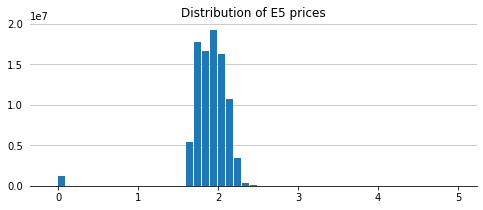

In [30]:
# Show e5 value distribution to identify outlier data ranges

# Distribution Histogram (incl. binnning)
from hana_ml.visualizers.eda import EDAVisualizer
f = plt.figure(figsize=(8,3))
ax1 = f.add_subplot(111)

eda = EDAVisualizer(ax1)
ax, dist_data = eda.distribution_plot( data=fuelprice_all_hdf, column="e5", bins=50, 
                                      title="Distribution of E5 prices", debrief=False)
plt.show()

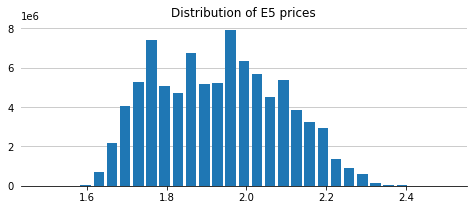

In [48]:
# Filter outliers
fuelprice_all_hdf=fuelprice_all_hdf.filter('"e5" > 1.3 and "e5"< 2.8')

# Distribution Histogram (incl. binnning)
from hana_ml.visualizers.eda import EDAVisualizer
f = plt.figure(figsize=(8,3))
ax1 = f.add_subplot(111)

eda = EDAVisualizer(ax1)
ax, dist_data = eda.distribution_plot( data=fuelprice_all_hdf, column="e5", bins=30, 
                                      title="Distribution of E5 prices", debrief=False)
plt.show()

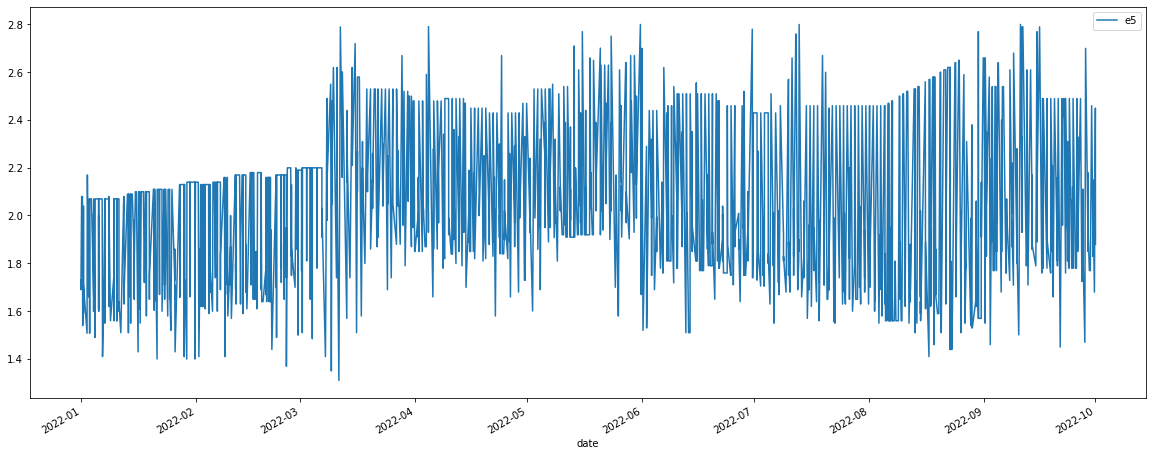

In [32]:
# M4 sampling and time series plot
%matplotlib inline
from hana_ml.visualizers.m4_sampling import m4_sampling
fuelprice_sample=m4_sampling(fuelprice_all_hdf.select('date', 'e5'), 200)
#fuelprice_sample.head(6).collect()

fuelprice_sample_pd=fuelprice_sample.collect()
fuelprice_sample_pd.set_index(fuelprice_sample_pd.columns[0], inplace=True)
fuelprice_sample_pd.sort_index(inplace=True)
fuelprice_sample_pd=fuelprice_sample_pd.astype(float)
#ax.set_ylim((1.3,2.8))
ax = fuelprice_sample_pd.plot(figsize=(20,8))

<AxesSubplot:>

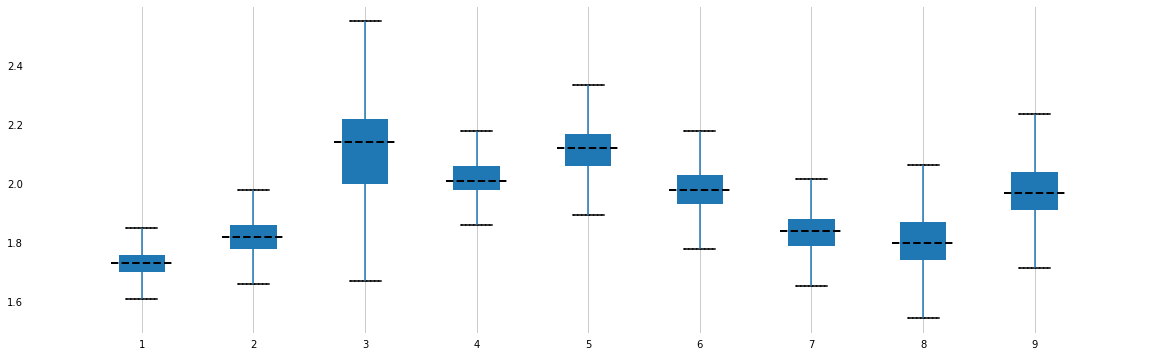

In [37]:
# timeseries_box_plot
from hana_ml.visualizers.eda import timeseries_box_plot
f = plt.figure(figsize=(20, 6))
timeseries_box_plot(data=fuelprice_sample, col="e5", key="date", cycle="MONTH")

# Exercise 5.3 - Forecast fuel prices

## Step 1 -  Select price data for local region

Demo

In [58]:
# Refelect number of service stations in local regrion close to SAP HQ
print("Number of Serice Stations in the Rhein-Neckar area", stations_rnk_hdf.count(), "\n")

# Create a fuel price data HANA dataframe, filtering to local area stations using HANA spatial intersect-filtering
fuelprice_rnk_hdf=conn.sql(
"""
select "date", "station_uuid", "e5" 
    from "RAW_DATA"."GAS_PRICES" 
    WHERE "station_uuid" 
         IN (SELECT "uuid" 
              FROM (SELECT * FROM "GAS_STATIONS") AS S, 
                   (SELECT * FROM "GEO_GERMANY_REGIONS" 
                    WHERE "krs_name"=\'Landkreis Rhein-Neckar-Kreis\' or "krs_name"=\'Stadtkreis Heidelberg\' 
                          or "krs_name"=\'Stadtkreis Mannheim\' ) AS G 
              WHERE "longitude_latitude_GEO".ST_SRID(25832).st_transform(25832).st_intersects(SHAPE)=1);
"""
)
display(fuelprice_rnk_hdf.collect())

Number of Serice Stations in the Rhein-Neckar area 171 



,date,station_uuid,e5
0,2022-08-15 17:37:08,0c7e5731-68c4-49f9-bcbc-87dbaa191294,1.749
1,2022-08-16 13:30:09,0c7e5731-68c4-49f9-bcbc-87dbaa191294,1.749
2,2022-08-15 13:33:09,0c7e5731-68c4-49f9-bcbc-87dbaa191294,1.749
3,2022-08-16 17:11:07,2645b215-8233-49dc-85f4-b389b284f624,1.749
4,2022-08-15 19:28:09,4e4f2acc-722d-4eb6-a71d-5c17bc5d5fe3,1.749
...,...,...,...
963519,2022-09-30 15:16:12,9f553817-0018-408c-9c23-4f5686419f5a,1.899
963520,2022-09-30 15:16:12,c080d550-c6ce-46d2-bc99-af48136c3ada,1.869
963521,2022-09-30 15:16:12,fb706efa-ebbc-406e-bef7-6c0c9ab205bd,1.909
963522,2022-09-30 15:16:12,63b7f9e0-8cd0-4016-baa6-9d7d77328070,1.829


In [59]:
print( "The dataset covers the time period starting from: ")
print( fuelprice_rnk_hdf.sort('date').select('date').head(1).collect(), "\n")
print( "... and ends at: ")
print( fuelprice_rnk_hdf.sort('date', desc=True).select('date').head(1).collect())

The dataset covers the time period starting from: 
                 date
0 2022-01-01 00:02:17 

... and ends at: 
                 date
0 2022-09-30 23:32:06


In [62]:
# in order to predict the last 7 days, we restict our training data to be earlier than 2022-09-23
train_rnk_hdf  = fuelprice_rnk_hdf.filter('"date" < \'2022-09-23 00:00:00.000\'')

# ground truth
test_groundtruth_rnk_hdf  = fuelprice_rnk_hdf.filter('"date" >= \'2022-09-23 00:00:00.000\'')

# create test dataset, same as ground truth only target column values set to 0
test_rnk_hdf = test_groundtruth_rnk_hdf.drop(['e5'])
test_rnk_hdf = test_rnk_hdf.add_constant('e5', 0)
test_rnk_hdf = test_rnk_hdf.cast('e5', 'DOUBLE')

#test_groundtruth_rnk_hdf.sort('date').head(3).collect()
print('Number of forecast training rows', train_rnk_hdf.count())
print('Number of forecast testing rows', test_rnk_hdf.count())

Number of forecast training rows 934157
Number of forecast testing rows 29367


## Step 2 - Model fuel price forecast
using Prophet (Additive Model Forecast)  
Massive Mode Support available for ARIMA, Auto ARIMA, Additive Model Forecast, UnifiedClassification, UnifiedRegression.

In [63]:
# Prepare holiday data table (for simplicity an empty table) for the forecast model function
conn.create_table(
    table='PAL_ADDITIVE_MODEL_ANALYSIS_HOLIDAY',
    schema='TECHED_USER_999',
    table_structure={'GROUP_IDXXX': 'INTEGER', 'ts': 'TIMESTAMP', 'NAME': 'VARCHAR(255)', 
                     'LOWER_WINDOW': 'INTEGER', 'UPPER_WINDOW': 'INTEGER'})
holiday_data_hdf = conn.sql('select * from "TECHED_USER_999"."PAL_ADDITIVE_MODEL_ANALYSIS_HOLIDAY"')

In [75]:
# Build a forecast model per station in parallel using PAL Additive Model Forecast (aka Prophet)-forecasting function
from hana_ml.algorithms.pal.tsa.additive_model_forecast import AdditiveModelForecast

amf = AdditiveModelForecast(massive=True,growth='linear',
                                changepoint_prior_scale=0.06,
                                weekly_seasonality='True',
                                daily_seasonality='True'
                                )

amf.fit(data=train_rnk_hdf, key="date", group_key="station_uuid", holiday=holiday_data_hdf)

amf.runtime

171.84995222091675

In [69]:
# Which SQL statement was actually executed in SAP HANA?

#print(conn.last_execute_statement)
print(amf.get_fit_execute_statement())

DO
BEGIN
DECLARE group_id NVARCHAR(100) ARRAY;
DECLARE param_name VARCHAR(5000) ARRAY;
DECLARE int_value INTEGER ARRAY;
DECLARE double_value DOUBLE ARRAY;
DECLARE string_value VARCHAR(5000) ARRAY;
group_id[1] := N'PAL_MASSIVE_PROCESSING_SPECIAL_GROUP_ID';
param_name[1] := N'GROWTH';
int_value[1] := NULL;
double_value[1] := NULL;
string_value[1] := N'linear';
group_id[2] := N'PAL_MASSIVE_PROCESSING_SPECIAL_GROUP_ID';
param_name[2] := N'WEEKLY_SEASONALITY';
int_value[2] := 1;
double_value[2] := NULL;
string_value[2] := NULL;
group_id[3] := N'PAL_MASSIVE_PROCESSING_SPECIAL_GROUP_ID';
param_name[3] := N'DAILY_SEASONALITY';
int_value[3] := 1;
double_value[3] := NULL;
string_value[3] := NULL;
group_id[4] := N'PAL_MASSIVE_PROCESSING_SPECIAL_GROUP_ID';
param_name[4] := N'CHANGEPOINT_PRIOR_SCALE';
int_value[4] := NULL;
double_value[4] := 0.06;
string_value[4] := NULL;
params = UNNEST(:group_id, :param_name, :int_value, :double_value, :string_value);
in_0 = SELECT "station_uuid", "date", "e5" FR

In [65]:
# How do the AdditiveModelAnalysis segmented model look like?
pd.set_option('max_colwidth', None)
df=amf.model_.head(5).collect()

display(df.style.set_properties(**{'text-align': 'left'}))

,GROUP_ID,ROW_INDEX,MODEL_CONTENT
0,0e64e4c6-3d58-44d4-bbe5-377a5a0db2f2,0,"{""GROWTH"":""linear"",""FLOOR"":0.0,""SEASONALITY_MODE"":""additive"",""start"":""2022-01-01 07:04:21.0000000"",""y_scale"":2.279,""t_scale"":22858068.0,""cat_field_moments"":"""",""seasonality_name"":[[""daily"",""weekly""]],""seasonality_period"":[[1.0,7.0]],""seasonality_fourier_order"":[[4.0,3.0]],""seasonality_prior_scale"":[[10.0,10.0]],""seasonality_mode"":[[0,0]],""k"":0.16905147208419855,""m"":0.6747837028704113,""delta"":[[0.000019855436480770303,-0.003139637662435646,0.01679415930537439,-0.0328133049267626,-0.27360721610263186,2.2353936376905745,1.7666466807584179,-4.576067679116404,-0.15681888747492085,-0.00033573103873196276,0.14485727184034406,1.0586197528280708,-0.0024972567359713238,0.0260837738311591,0.0481478819212962,0.0014836234780521848,-2.321147927061606,1.6709063034691847,0.005396985160030785,-0.3910978524193159,-0.006825204880160806,0.09470872093528066,-0.004691954762746377,-0.23052082667237665,1.3019344966827458]],""sigma_obs"":0.02173282163421346,""beta"":[[-0.0118323992058886,-0.12673192273546173,-0.04951517181024579,-0.09912837289110321,-0.054766086948141317,-0.038751734885562449,-0.022701901282780634,-0.002764645255531139,0.0021537149845288377,-0.005134606278153353,-0.0013161485774701354,0.001050481542735515,0.001886375127655609,-0.00025728681794776314]],""changepoints_t"":[[0.03126209091687014,0.06575043875099156,0.09877418336492831,0.1304356081187614,0.16397129451185464,0.19373758972105604,0.22760676886603016,0.2589504064822976,0.29206615362243218,0.3233075953750772,0.3549848132396841,0.3834701165470328,0.415908553601293,0.4476277697660187,0.48019228921709397,0.5084229778299724,0.5418090890271217,0.5747145821772863,0.6065861734246306,0.6398645764812669,0.6769385321629107,0.708321761926686,0.7428654075226305,0.776311803779742,0.809537752709459]],""holidays_prior_scale"":10.0}"
1,0e5f8257-c5e6-44f2-8d7f-4ba90f7b9646,0,"{""GROWTH"":""linear"",""FLOOR"":0.0,""SEASONALITY_MODE"":""additive"",""start"":""2022-01-01 00:06:11.0000000"",""y_scale"":2.349,""t_scale"":22882198.0,""cat_field_moments"":"""",""seasonality_name"":[[""daily"",""weekly""]],""seasonality_period"":[[1.0,7.0]],""seasonality_fourier_order"":[[4.0,3.0]],""seasonality_prior_scale"":[[10.0,10.0]],""seasonality_mode"":[[0,0]],""k"":0.051652180310456017,""m"":0.735176843058311,""delta"":[[0.00001600939299196334,0.09291902580088094,0.16143389256818153,-0.000027265509194837965,-0.33404783415902919,2.062016868311476,1.046102165345993,-4.461597356943375,0.7168997458255622,0.09555097254853488,0.4165569526017304,0.40940346985828565,0.026480456080889528,0.23051449880173167,0.19022212727265018,-0.6455275264640256,-1.3831263206901064,0.7708832558403918,0.003384549901830661,-0.14229914520585788,0.040149843214075737,0.11228748656162813,-0.0006325271997385875,-0.30237272121092298,1.4015066283961622]],""sigma_obs"":0.02337325903132265,""beta"":[[0.029527925353901409,-0.006715066273355299,0.006555785427283219,-0.009862643631695454,0.002307965245686061,-0.002608988762988435,0.0036138814424708685,-0.0016114232947575718,-0.002351028457307764,0.004021637433438979,0.003648674141465862,-0.002202558412935778,0.00042237002978908573,0.001325286109493763]],""changepoints_t"":[[0.03223881726746705,0.06256112284318141,0.09593558276176091,0.12997339678644508,0.1634500759061695,0.19515411063220412,0.22899277420814208,0.26688777887508888,0.3001756212405819,0.33117430414683066,0.3618847280318088,0.3941237201076575,0.4252509308764831,0.4544303829553437,0.4825155782674374,0.5128037962087384,0.5449589239635109,0.5721004162274971,0.6024936503040486,0.6332642519743951,0.6637621088673387,0.700456223654738,0.734394396901906,0.7653195291815935,0.7993836518677095]],""holidays_prior_scale"":10.0}"
2,018e8f3e-ae2f-40bc-89c1-bc3fe20eb462,0,"{""GROWTH"":""linear"",""FLOOR"":0.0,""SEASONALITY_MODE"":""additive"",""start"":""2022-01-01 00:02:17.0000000"",""y_scale"":2.289,""t_scale"":22883512.0,""cat_field_

In [ ]:
# Filter errornous test data
#test_rnk_hdf=test_rnk_hdf.filter('"station_uuid" not in (\'3ec1e50e-aba5-436c-960a-423b2b8a37ed\', \'51d4b58a-a095-1aa0-e100-80009459e03a\')')

# predict returns an array of three dataframes. The first contains the forecasted values
fc_result, fc_decomp, fc_error = amf.predict(data=test_rnk_hdf, key="date", group_key="station_uuid")

#print(amf.get_predict_execute_statement())

# look at forecast result data
display(fc_result.head(3).collect(), "\n")

# Look the time series decomposition result data
fc_decomp.head(3).collect()

# Check for errors in any of the station_uuids
fc_error.head(3).collect()

## Step 3 - Evaluate Forecast Accuracy

In [126]:
# Create a Forecast accuracy-measures table
conn.create_table(table='FORECAST_ACCURACY',schema='TECHED_USER_999', 
                 table_structure={'station_uuid': 'NVARCHAR(5000)', 'STAT_NAME': 'NVARCHAR(10)', 'STAT_VALUE': 'DOUBLE'})
fc_acc=conn.table('FORECAST_ACCURACY')
fc_acc.count()

0

In [103]:
# Comparing predicted Forecast with observed ground-truth e5-values of the test data time period

# predicted forecast
fc_allgroups=fc_result.select('date', 'GROUP_ID', 'YHAT', 'YHAT_LOWER', 'YHAT_UPPER').rename_columns({'YHAT': 'PREDICTED'})
#display(fc_allgroups.head(2).collect())

# actual groundthruth
act_allgroups=test_groundtruth_rnk_hdf.sort('date', desc=True).rename_columns({'e5': 'ACTUAL'})
#display(act_allgroups.head(2).collect())

# combined actual and predicted values
testacc_allgroups=act_allgroups.alias('A').join(fc_allgroups.alias('F'), 
          'A."station_uuid"=F."GROUP_ID" and A."date" = F."date"',
          select=['station_uuid', ('A."date"', 'DATE'), 'ACTUAL', 'PREDICTED']).sort('DATE')
testacc_allgroups=testacc_allgroups.sort('DATE')
#print(testacc_allgroups.select_statement)
display(testacc_allgroups.head(10).collect())

,station_uuid,DATE,ACTUAL,PREDICTED
0,aab0ca78-c465-4f09-9307-c9739c814516,2022-09-23 00:34:09,1.929,1.986540
1,1dc632bf-90c5-4971-8420-a74a842203c1,2022-09-23 00:34:09,1.919,1.997717
2,417722f4-761a-4e8e-a750-104aef3181df,2022-09-23 00:36:05,1.979,1.951235
3,b6a3937b-bc37-43d4-b206-c31d6bb74300,2022-09-23 00:44:09,1.899,2.006659
4,16c7cc25-cfdf-4e18-81b3-90d7f17f35fe,2022-09-23 03:55:10,1.919,1.964504
5,cbce0ea0-12da-4e3a-a42d-af57bee17ce7,2022-09-23 04:14:09,1.819,1.935188
6,ce8820a8-1968-404c-9072-fd3a32d7c61d,2022-09-23 04:54:09,2.109,2.073659
7,a3b3f1e3-9bb8-4869-88b3-ef0238de18e2,2022-09-23 05:01:09,2.139,2.112500
8,f68ad3b1-44c2-47b0-ba9b-eb23163b7ee3,2022-09-23 05:01:09,2.139,2.102763
9,80cc039e-493e-4b2b-a9e0-1044b6c63329,2022-09-23 05:01:09,2.139,2.102726


In [127]:
# Get alls stations uuids into a list
df=testacc_allgroups.distinct('station_uuid').collect()
stations_all=list(set(list(df['station_uuid'])))
#print(stations_all)

# Calculate Forecast Accuracy Measure for each station 
from hana_ml.algorithms.pal.tsa.accuracy_measure import accuracy_measure
amres = {}
for station in stations_all:
    amres[station] = accuracy_measure(data=testacc_allgroups.filter('"station_uuid"=\'{}\''.format(station)
                                                                   ).select(['ACTUAL', 'PREDICTED']),
                                      evaluation_metric=['mse', 'rmse', 'mpe', 'et',
                                                         'mad', 'mase', 'wmape', 'smape',
                                                         'mape'])
   
    amres[station]=amres[station].select(('\'{}\''.format(station),'station_uuid'), 'STAT_NAME', 'STAT_VALUE')
    amres[station].save('FORECAST_ACCURACY', append=True)
    
fc_acc.collect()

,station_uuid,STAT_NAME,STAT_VALUE
0,7ffcab6b-358a-4309-ace7-92cd8a20bc81,ET,-17.256384
1,7ffcab6b-358a-4309-ace7-92cd8a20bc81,MAD,0.109558
2,7ffcab6b-358a-4309-ace7-92cd8a20bc81,MAPE,0.057563
3,7ffcab6b-358a-4309-ace7-92cd8a20bc81,MASE,2.586343
4,7ffcab6b-358a-4309-ace7-92cd8a20bc81,MPE,-0.056130
...,...,...,...
1399,e1e4230d-98d0-433b-ad28-bf673862592f,MPE,-0.029953
1400,e1e4230d-98d0-433b-ad28-bf673862592f,MSE,0.005010
1401,e1e4230d-98d0-433b-ad28-bf673862592f,RMSE,0.070779
1402,e1e4230d-98d0-433b-ad28-bf673862592f,SMAPE,0.033131


In [124]:
#Visually evaluate a specific station
station='018e8f3e-ae2f-40bc-89c1-bc3fe20eb462'

# Filter forecast train data (actuals) for station
act_train_1s=train_rnk_hdf.filter('"station_uuid" = \'{}\''.format(station)).sort('date', desc=False)
act_train_1s=act_train_1s.drop('station_uuid').rename_columns({'e5': 'ACTUAL'})
#act_train_1s.head(2).collect()

# Filter test data ground thruth (actuals) for station
act_gt_1s=test_groundtruth_rnk_hdf.filter('"station_uuid" = \'{}\''.format(station)).sort('date', desc=False)
act_gt_1s=act_gt_1s.drop('station_uuid').rename_columns({'e5': 'E5_ACTUAL'})
#act_gt_1s.head(2).collect()

# Union actuals into one set
actual_1s=act_train_1s.union(act_gt_1s).sort('date')
display(actual_1s.head(10).collect())

# Filter forecast predictions
forecast_1s=fc_result.filter('"GROUP_ID" = \'{}\''.format(station)).sort('date', desc=False)
forecast_1s=forecast_1s.select('date', 'YHAT', 'YHAT_LOWER', 'YHAT_UPPER').rename_columns({'YHAT': 'PREDICTED'})
display(forecast_1s.head(2).collect())

,date,ACTUAL
0,2022-01-01 00:02:17,1.749
1,2022-01-01 07:01:08,1.779
2,2022-01-01 09:02:18,1.829
3,2022-01-01 09:45:28,1.779
4,2022-01-01 10:10:11,1.729
5,2022-01-01 12:01:10,1.779
6,2022-01-01 12:11:08,1.779
7,2022-01-01 12:40:07,1.719
8,2022-01-01 13:31:15,1.709
9,2022-01-01 13:52:11,1.689


,date,PREDICTED,YHAT_LOWER,YHAT_UPPER
0,2022-09-23 05:01:09,2.010863,1.949658,2.068862
1,2022-09-23 07:46:09,1.955674,1.894689,2.016800


In [130]:
# create csv files
actual_1s_pd = actual_1s.collect()
actual_1s_pd.to_csv('plot_actuals.csv')

forecast_1s_pd = forecast_1s.collect()
forecast_1s_pd.to_csv('plot_predicted.csv')


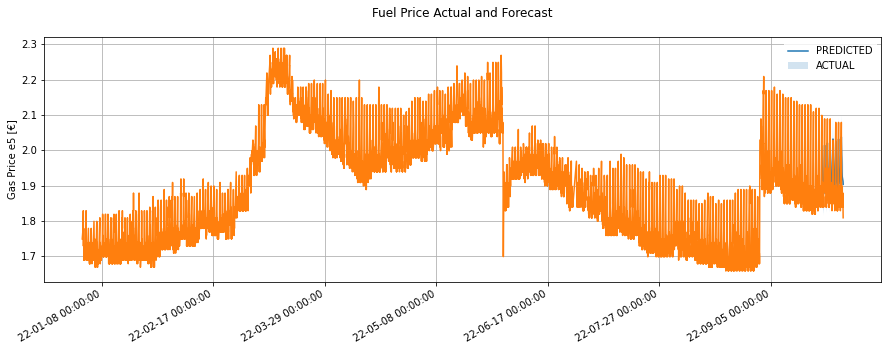

In [129]:
# Forecast-Lineplot for the complete period
from hana_ml.visualizers.visualizer_base import forecast_line_plot
ax = forecast_line_plot(actual_data=actual_1s.set_index("date"),
                        pred_data=forecast_1s.set_index("date"),                
                    confidence=("YHAT_LOWER", "YHAT_UPPER"),
                    max_xticklabels=10, figsize=(15, 5))

ax.set_title('Fuel Price Actual and Forecast', pad=20)
plt.ylabel('Gas Price e5 [€]')
plt.show()

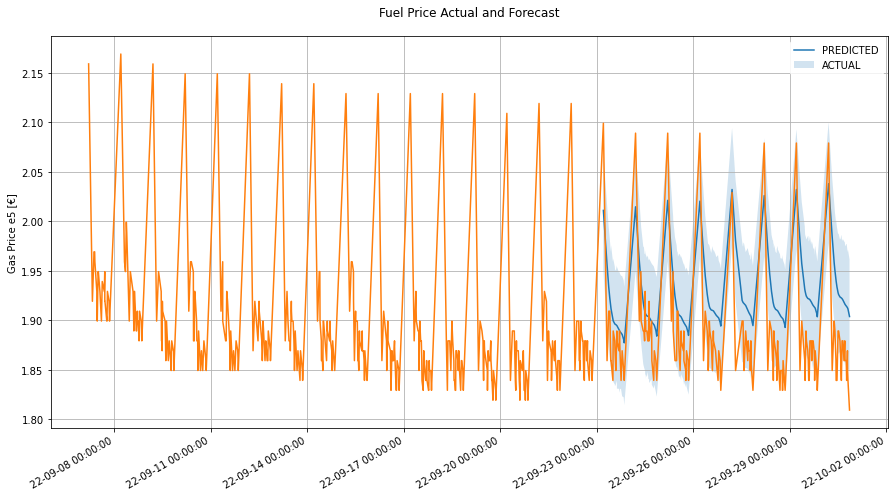

In [125]:
# Forecast-Lineplot for the last 3 weeks of data
from hana_ml.visualizers.visualizer_base import forecast_line_plot
ax = forecast_line_plot(pred_data=forecast_1s.set_index("date"),
                    actual_data=actual_1s.filter('"date" >= \'2022-09-07 00:00:00.000\'').set_index("date"),
                    confidence=("YHAT_LOWER", "YHAT_UPPER"),
                    max_xticklabels=10, figsize=(15, 8))

ax.set_title('Fuel Price Actual and Forecast', pad=20)
plt.ylabel('Gas Price e5 [€]')
plt.show()

## Step 4 -  Execute forecast on new Data

In [ ]:
# load Data from last week, yesterday, ...
# -- retrain forecast
# -- forecast next 7 days